In [1]:
## Load modules
from os import path
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm import tqdm

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings

#User
import allen_v1dd.decoding.decoding as dc

%matplotlib inline
%load_ext autoreload
%autoreload 2

unique_stimIDs = [29,  4, 23, 32,  9, 47, 68, 62, 27,  6,  2,  5]
nStim = 12

In [3]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/home/dwyrick/data/v1dd_in_vivo_new_segmentation" # Local on Essun for golden mouse
client = V1DDClient(base_folder)

In [4]:
##===== Read in cell metrics =====##
metrics = pd.read_csv("../../dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)

# Only consider valid metrics
print(f"{np.count_nonzero(metrics.is_valid)}/{len(metrics)} ({np.mean(metrics.is_valid)*100:.1f}%) ROIs are valid")
metrics = metrics[metrics.is_valid & (metrics.mouse == 409828) & (metrics.column == 1)]

metrics.head()

9714/52826 (18.4%) ROIs are valid


,mouse,column,volume,plane,roi,is_valid,depth,dgf_pref_response,dgf_pref_dir,dgf_pref_sf,...,dgw_null_dist_single_std,dgw_resp_pref_dgf,dgf_resp_pref_dgw,ssi,ffsi,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std
M409828_11_1_89,409828,1,1,1,89,True,50,0.000943,330.0,0.08,...,0.000450,0.000710,0.000586,0.265065,0.419054,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903
M409828_11_2_0,409828,1,1,2,0,True,66,0.000919,270.0,0.08,...,0.000653,0.000394,0.000911,-0.084075,-0.183585,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629
M409828_11_2_1,409828,1,1,2,1,True,66,0.011217,0.0,0.08,...,0.000538,0.002046,0.009295,-0.065169,-0.139425,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262
M409828_11_2_2,409828,1,1,2,2,True,66,0.001237,120.0,0.04,...,0.000582,0.000344,0.000369,0.536319,0.698187,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412
M409828_11_2_4,409828,1,1,2,4,True,66,0.001093,240.0,0.04,...,0.000381,0.000221,0.000660,-0.034136,-0.070685,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601


In [5]:
np.unique(metrics['depth'].values)

depth_ranges = []

for i in range(7):
    iStart = i*100
    iEnd = (i+1)*100
    depth_ranges.append([iStart,iEnd])


Text(0.5, 0, 'SSI')

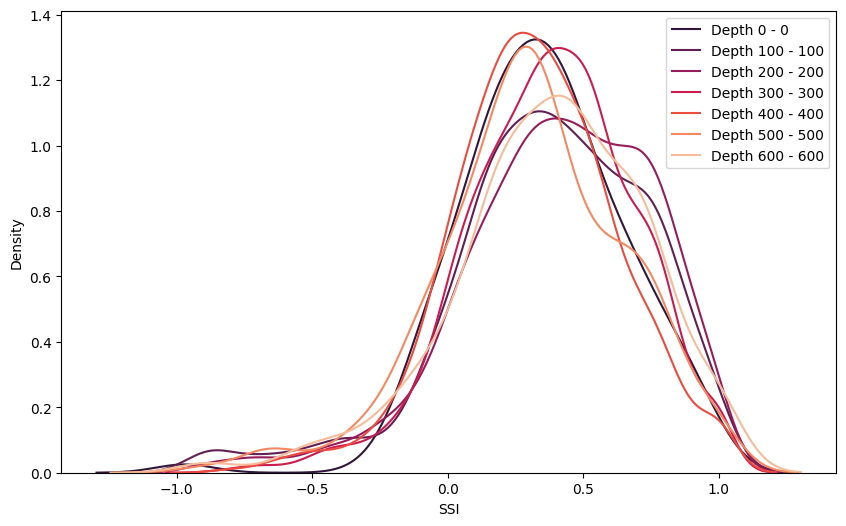

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
cmap = sns.color_palette("rocket", n_colors=len(depth_ranges))
for ii,dp in enumerate(depth_ranges):
    sns.kdeplot(metrics.loc[(metrics.depth > dp[0]) & (metrics.depth <= dp[1])]['ssi'].values, ax=ax,label=f'Depth {dp[0]} - {dp[0]}',color=cmap[ii])#,stat='density',kde=True)
ax.legend()
ax.set_xlabel('SSI')

In [7]:
##===== Load session from golden mouse =====##
goldenmouse_id = 409828; col = 1; vol = 3
sess = client.load_ophys_session(mouse=goldenmouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [8]:
metrics_sub = metrics.loc[(metrics.mouse == 409828) & (metrics.column == 1) & (metrics.volume == '3')] #


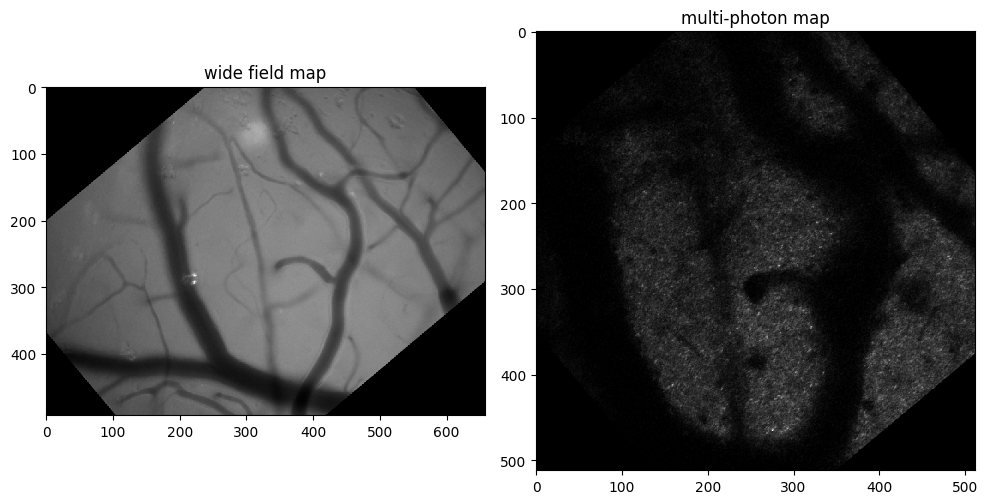

In [9]:
## From the file object get the surface vasculature map
vasmap_wf = sess.get_vasculature_map(type='wf', is_standard=True)
vasmap_mp = sess.get_vasculature_map(type='mp', is_standard=True)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axs[0].imshow(vasmap_wf, cmap='gray', interpolation='nearest')
axs[0].set_title('wide field map')
axs[1].imshow(vasmap_mp, cmap='gray', interpolation='nearest')
axs[1].set_title('multi-photon map')
fig.tight_layout()

In [10]:
# Each two-photon session has 6 planes, 'plane0' to 'plane5' with increasing cortical depth. Each three-photon session has only one plane, 'plane0'.
# select 1 imaging plane from the session
plane = sess.get_planes()[0]

#Get that experiment ID
exp_id = sess.get_lims_experiment_id(plane)

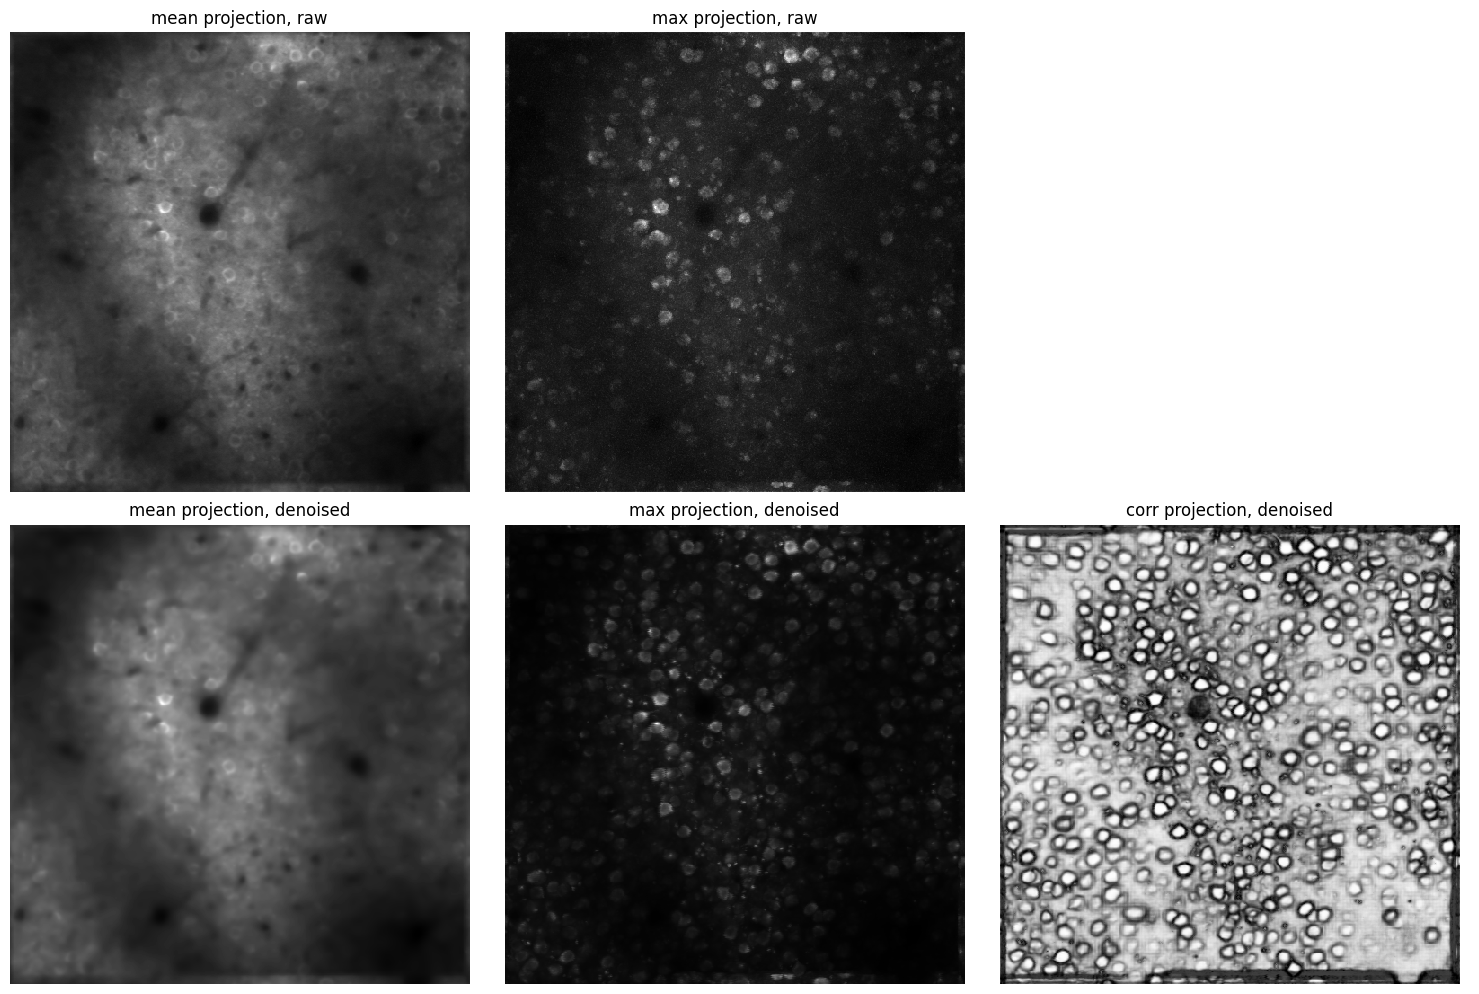

In [11]:
# From the file object and the plane name, get the mean, max, and correlation projections of this imaging plane
proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axs[0, 0].imshow(proj_raw_mean, cmap='gray', interpolation='nearest')
axs[0, 0].set_title('mean projection, raw')
axs[0, 1].imshow(proj_raw_max, cmap='gray', interpolation='nearest')
axs[0, 1].set_title('max projection, raw')
axs[1, 0].imshow(proj_de_mean, cmap='gray', interpolation='nearest')
axs[1, 0].set_title('mean projection, denoised')
axs[1, 1].imshow(proj_de_max, cmap='gray', interpolation='nearest')
axs[1, 1].set_title('max projection, denoised')
axs[1, 2].imshow(proj_de_corr, cmap='gray', interpolation='nearest')
axs[1, 2].set_title('corr projection, denoised')

for ax in axs.flat:
    ax.set_axis_off()

fig.tight_layout()

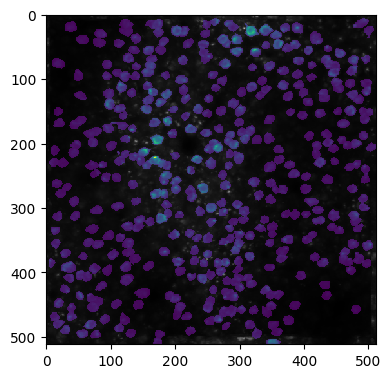

In [12]:
# Each two-photon session has 6 planes, 'plane0' to 'plane5' with increasing cortical depth. Each three-photon session has only one plane, 'plane0'.
# select 1 imaging plane from the session
plane = sess.get_planes()[0]

#Get that experiment ID
exp_id = sess.get_lims_experiment_id(plane)

#Get dff traces
dff_full, ts_full = sess.get_traces(plane, trace_type='dff')

#Only take valid cells
mask = sess.is_roi_valid(plane)
indy = np.where(mask)[0]

#Subsample
dff = dff_full[indy]; ts = ts_full
roi_ids = np.array(sess.get_rois(plane))
roi_ids_valid = roi_ids[indy]

##===== Plot where valid cells are in plane =====##
mask = sess.get_roi_image_mask(plane, roi_ids_valid)
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(proj_de_max, cmap='gray', interpolation='nearest')
ax.imshow(np.ma.masked_where(~mask,proj_de_max), cmap='viridis', interpolation='nearest')
# ax.imshow(mask, interpolation='nearest', cmap='gray')
fig.tight_layout()

In [13]:
stim_table, stim_meta = sess.get_stimulus_table("natural_images_12")

#Get start and end times for stimulus type
tStart = stim_table.start.values[0]
tEnd = stim_table.end.values[-1]
print(f"start={tStart}, end={tEnd}")

#Get start and end indices for stimulus
from stimulus_analysis.timing_utils import find_nearest
iStart = find_nearest(ts, tStart)
iEnd = find_nearest(ts, tEnd)


start=1179.5711669921875, end=1331.68115234375


In [14]:
stim_meta

{'duration': 0.33,
 'image_description': ['hummingbirds',
  'tiger, facing camera',
  'rectangular window grids',
  'baboon',
  'salamander on leaf',
  '2 coyotes',
  'barbed wire post',
  'ladybug',
  'cheetah running',
  'bird chasing hawk',
  'jaguar',
  'elephant'],
 'image_index': array([29,  4, 23, 32,  9, 47, 68, 62, 27,  6,  2,  5], dtype=uint32),
 'n_trials': 40,
 'padding': 0,
 'num_samples': 480}

In [15]:
mean_stimulus_length = np.mean(stim_table['end'].values - stim_table['start'].values)*1000
mean_ISI = np.mean(stim_table.iloc[1:]['start'].values - stim_table.iloc[:-1]['end'].values)*1000

print('Mean stimulus length = {:.1f}ms; Mean ISI = {:.1f}ms'.format(mean_stimulus_length,mean_ISI))

Mean stimulus length = 300.2ms; Mean ISI = 16.7ms


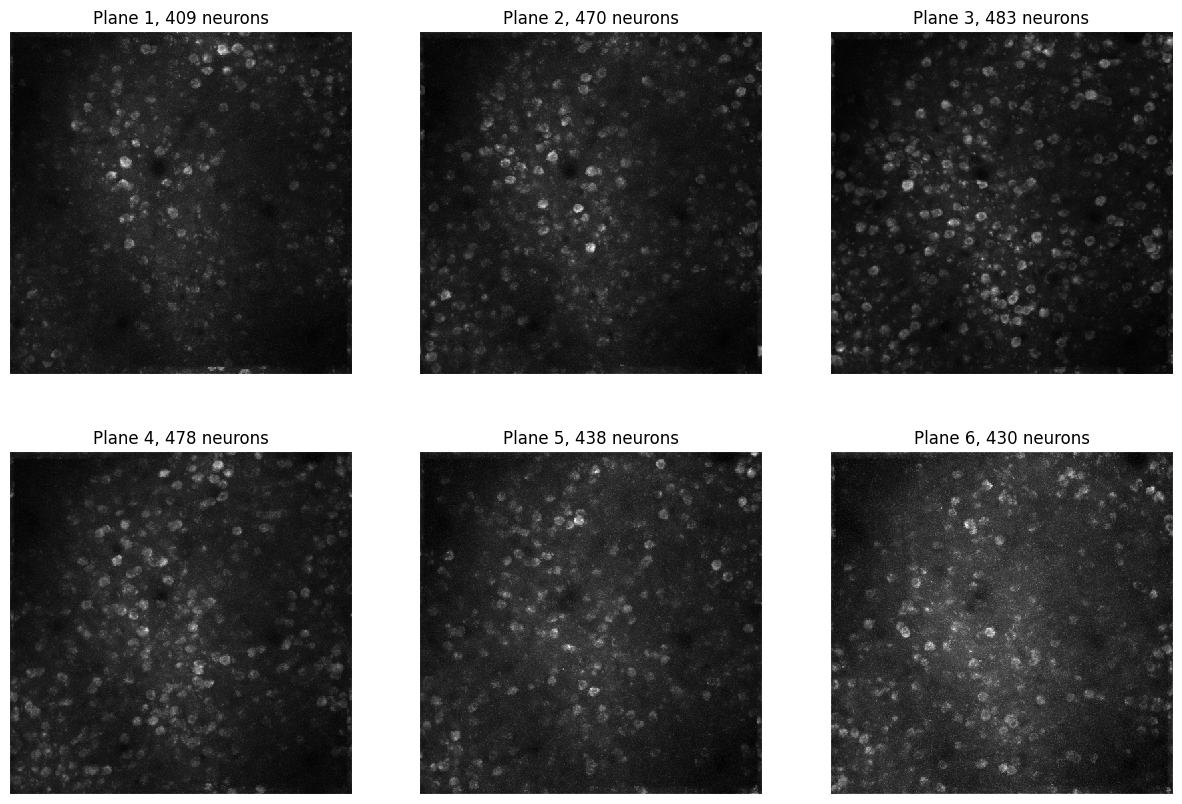

In [16]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

## Load data from all planes
data_dict = {plane: {} for plane in sess.get_planes()}
for ii, plane in enumerate(sess.get_planes()):
    #Get dff traces
    dff_full, ts_full = sess.get_traces(plane, trace_type='events')

    #Only take valid cells
    mask = sess.is_roi_valid(plane)
    indy = np.where(mask)[0]

    #Subsample
    dff = dff_full[indy]; ts = ts_full
    roi_ids = np.array(sess.get_rois(plane))
    roi_ids_valid = roi_ids[indy]

    data_dict[plane]['dff'] = dff
    data_dict[plane]['ts'] = ts

    ##Get image
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

    # valid = sess.is_roi_valid(plane); indy = np.where(valid)[0]
    # mask = sess.get_roi_image_mask(plane, np.array(sess.get_rois(plane))[indy])

    ax = axes[ii//3,ii%3]; ax.axis('off')
    # ax.imshow(np.ma.masked_where(~mask,proj_de_max), cmap='viridis', interpolation='nearest')
    ax.imshow(proj_raw_max, cmap='gray', interpolation='nearest')
    ax.set_title(f'Plane {plane}, {dff.shape[0]} neurons')


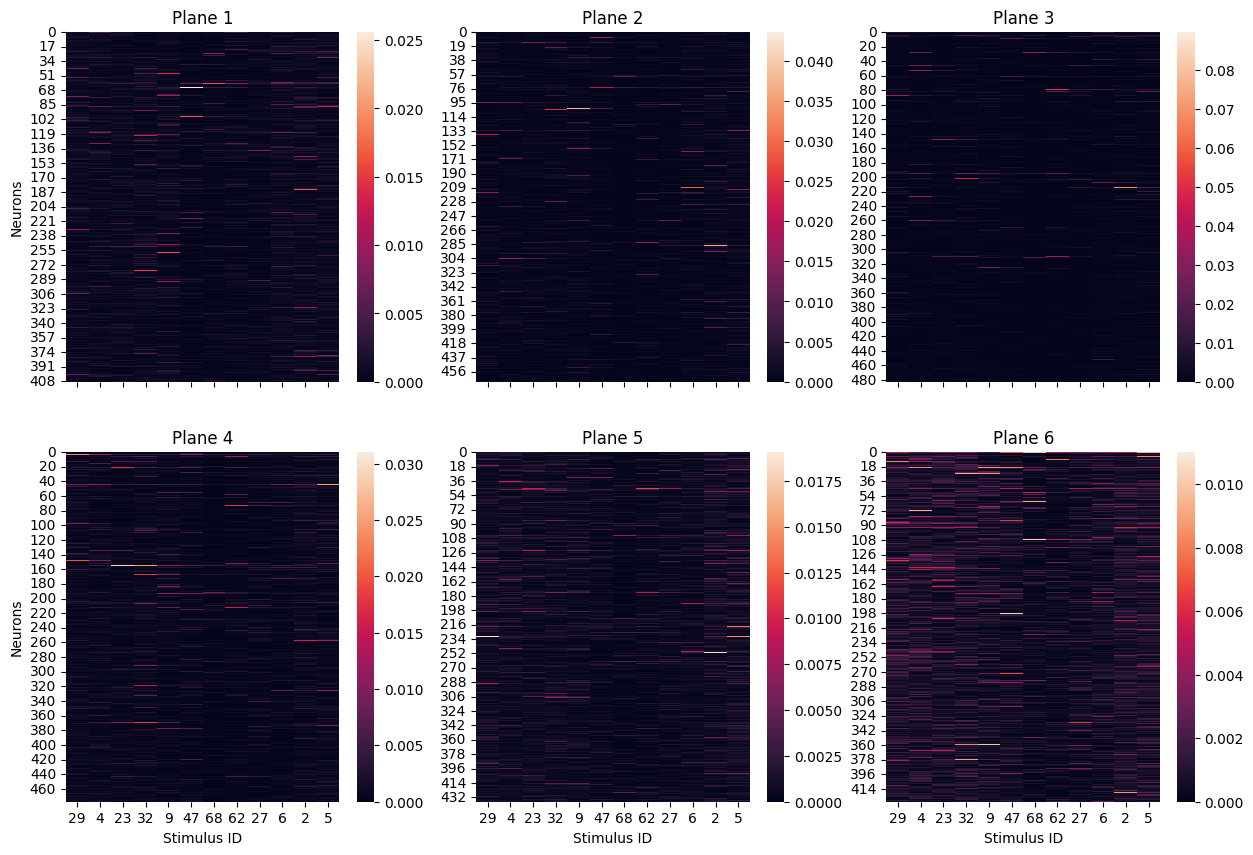

In [17]:
imageIDs = np.unique(stim_table['image'])
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

## Create PSTH heatmaps for 12 natural images 
for ii, plane in enumerate(sess.get_planes()):
    dff = data_dict[plane]['dff']
    ts = data_dict[plane]['ts']

    PSTH_list = []
    for iImg in imageIDs:
        indy = np.where(stim_table['image'] == iImg)[0]

        resp_list = []
        for index, row in stim_table.iloc[indy].iterrows():
            #Get stimulus presentation time
            tStart = row.start; tEnd = row.end

            iStart = find_nearest(ts, tStart)
            iEnd = find_nearest(ts, tEnd)

            response = np.mean(dff[:,slice(iStart,iEnd)],axis=1)
            resp_list.append(response)
        mean_response = np.mean(np.array(resp_list).T,axis=1)
        PSTH_list.append(mean_response)
    
    ax = axes[ii//3,ii%3]#; ax.axis('off')
    ax.set_title(f'Plane {plane}')
    sns.heatmap(np.array(PSTH_list).T,ax=ax,cmap='rocket')
    if ii % 3 == 0:
        ax.set_ylabel('Neurons')

    if ii//3 == 1:
        ax.set_xlabel('Stimulus ID')
        ax.set_xticklabels(unique_stimIDs)
    else:
        ax.set_xticklabels([])


            
        


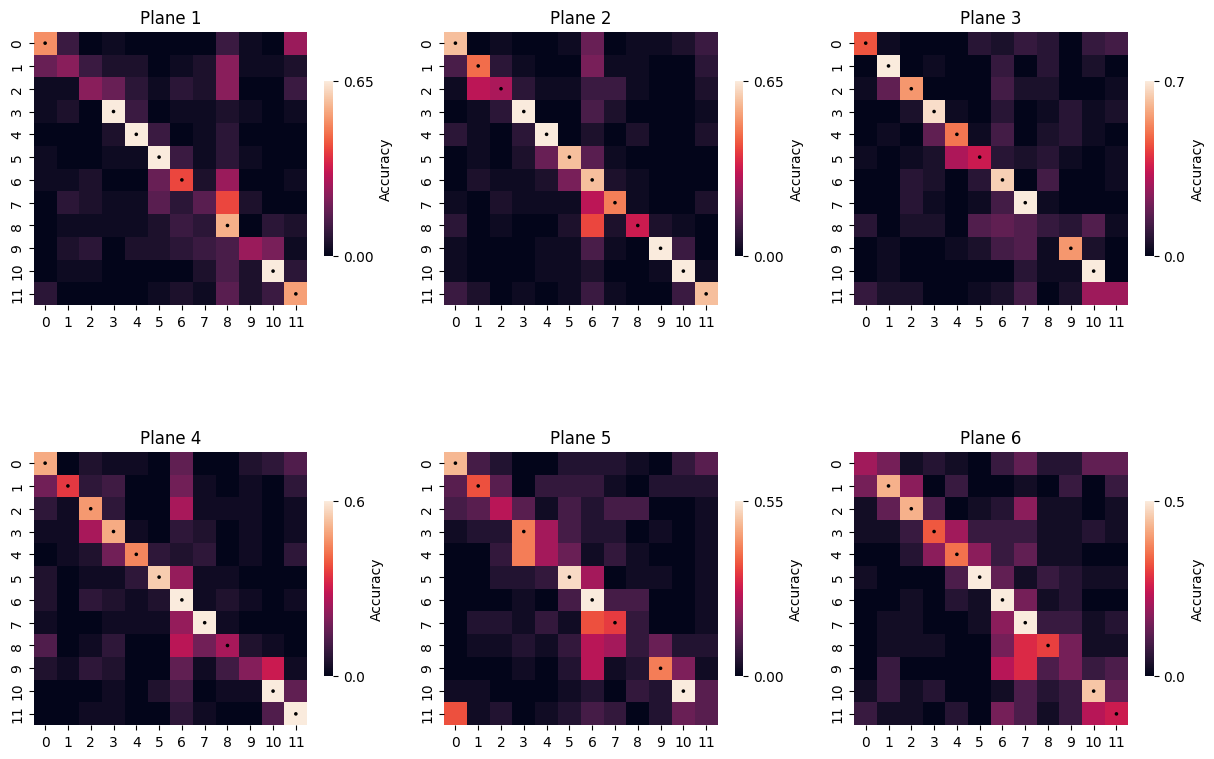

In [18]:
classifier = 'SVM'
method = 'kfold'
dim_reduce = False
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

##===== Perform decoding of natural images per plane =====##
for ii, plane in enumerate(sess.get_planes()):
    # plane = 1

    ax = axes[ii//3,ii%3]#; ax.axis('off')
    ax.set_title(f'Plane {plane}')

    dff = data_dict[plane]['dff']
    ts = data_dict[plane]['ts']

    resp_list = []
    for index, row in stim_table.iterrows():
        tStart = row.start; tEnd = row.end

        iStart = find_nearest(ts, tStart)
        iEnd = find_nearest(ts, tEnd)

        #Average response over window (usually just 2 bins)
        response = np.mean(dff[:,slice(iStart,iEnd)],axis=1)
        resp_list.append(response)

    X = np.array(resp_list,dtype='float64')
    Y = stim_table['image'].values

    if dim_reduce:
        pca = PCA(n_components=0.99)
        X_pca = pca.fit_transform(X)
        nComponents_pca = X_pca.shape[-1]
        print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
        confusion_mat, confusion_shf, confusion_z,pvalues, decoding_weights, decoding_weights_z = dc.cross_validate(X_pca, Y, classifier=classifier, method=method, shuffle=True, plot_shuffle=False, parallel=False)


    confusion_mat, confusion_shf, confusion_z, pvalues, decoding_weights, decoding_weights_z  = dc.cross_validate(X, Y, classifier=classifier, method=method, shuffle=True, plot_shuffle=False, parallel=False)
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,annot=False,ax=ax)
        
    


In [18]:
classifier = 'SVM'
method = 'kfold'
plane = 3

dff = data_dict[plane]['dff']
ts = data_dict[plane]['ts']

resp_list = []
for index, row in stim_table.iterrows():
    tStart = row.start; tEnd = row.end

    iStart = find_nearest(ts, tStart)
    iEnd = find_nearest(ts, tEnd)

    #Average response over window (usually just 2 bins)
    response = np.mean(dff[:,slice(iStart,iEnd)],axis=1)
    resp_list.append(response)

X = np.array(resp_list,dtype='float64')
Y = stim_table['image'].values

nTrials, nNeurons = X.shape


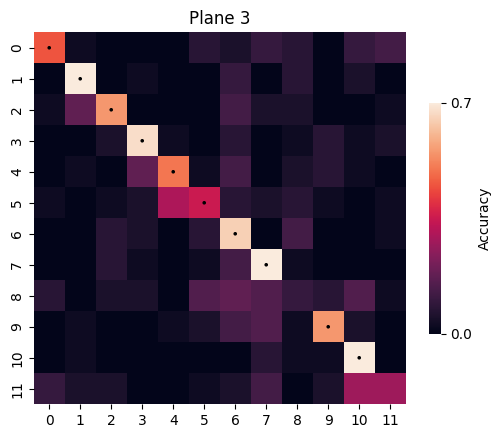

In [19]:
classifier = 'SVM'
method = 'kfold'

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title(f'Plane {plane}')

confusion_mat, confusion_shf, confusion_z, pvalues, decoding_weights, decoding_weights_z = dc.cross_validate(X, Y, classifier=classifier, method=method, shuffle=True, plot_shuffle=False, parallel=False)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,annot=False,ax=ax)
    


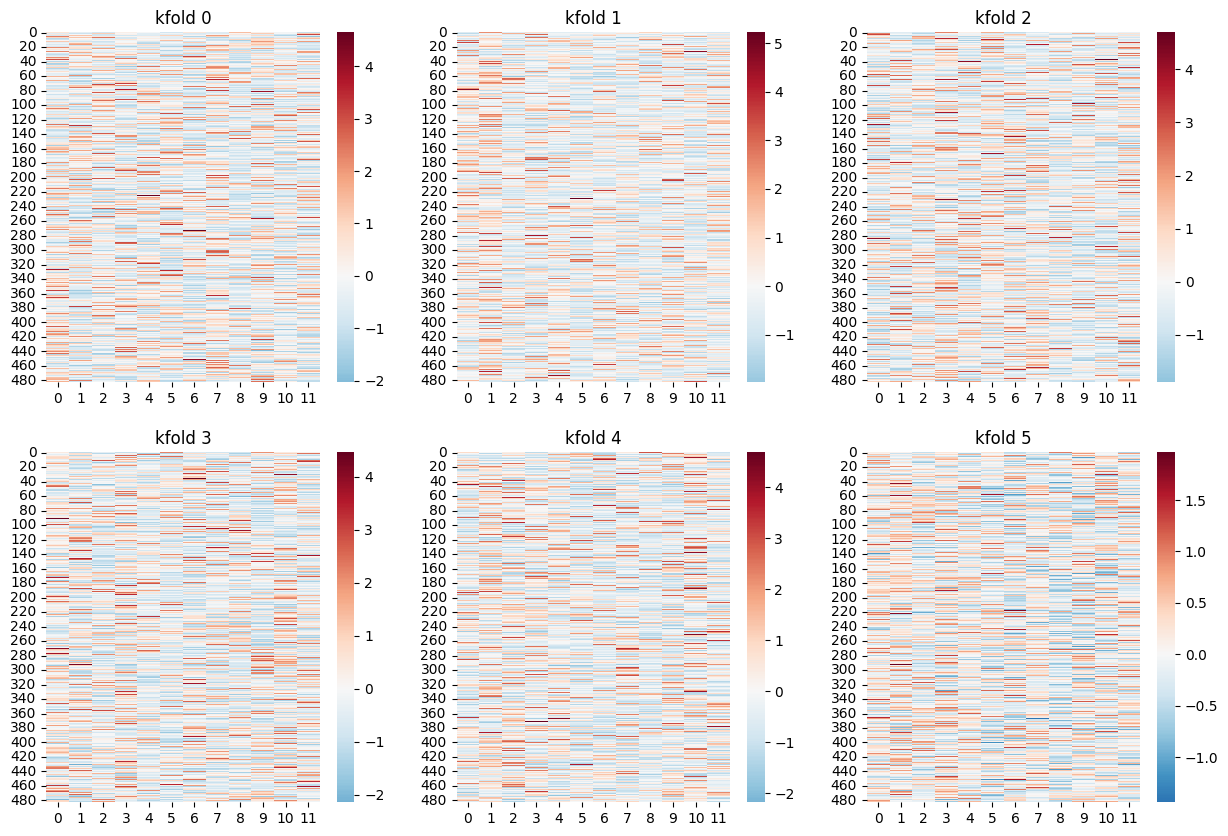

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
informative_neurons_kfold = []
neurons_numimgs = []
##===== Perform decoding of natural images per plane =====##
for ii in range(6):
    ax = axes[ii//3,ii%3]#; ax.axis('off')
    if ii == 5:
        dw = np.mean(decoding_weights_z,axis=0).T
    else:
        dw = np.array(decoding_weights_z[ii]).T
    ax.set_title(f'kfold {ii}')

    if ii % 3 == 0:
        ax.set_ylabel('Neurons')

    if ii//3 == 1:
        ax.set_xlabel('Stimulus ID')
        ax.set_xticks(np.arange(nStim))
        ax.set_xticklabels(unique_stimIDs)

    mask = (dw > 2) | (dw < -2)

    sns.heatmap(dw,ax=ax,cmap='RdBu_r',center=0)#,mask=~mask)
    if ii == 5:
        continue
    informative_neurons = np.where(np.sum(mask,axis=1) > 0)[0]
    neurons_numimgs.append(np.sum(mask,axis=1))
    informative_neurons_kfold.append(informative_neurons)

from functools import reduce
informative_neurons = reduce(np.intersect1d, (informative_neurons_kfold))


# informative_neurons = np.unique(np.concatenate(informative_neurons_kfold))
noninformative_neurons = np.setdiff1d(np.arange(nNeurons),informative_neurons)

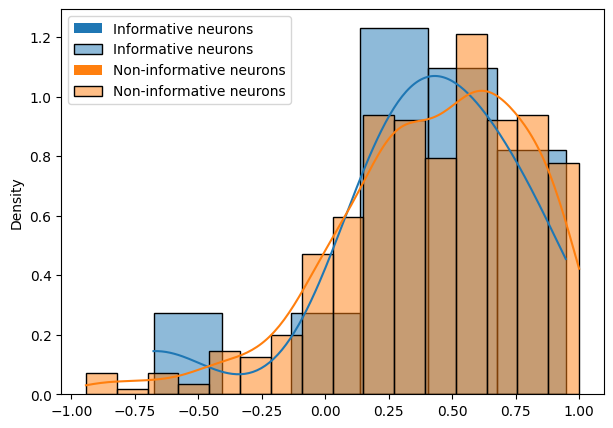

In [22]:
metrics_plane = metrics_sub.loc[metrics_sub.plane == plane]


fig, ax = plt.subplots(figsize=(7,5))

sns.histplot(metrics_plane.iloc[informative_neurons]['ssi'].values,stat='density',kde=True,ax=ax,label='Informative neurons')
sns.histplot(metrics_plane.iloc[noninformative_neurons]['ssi'].values,stat='density',kde=True, ax=ax,label='Non-informative neurons')

ax.legend()

# Look at other natural image dataset

In [24]:
stim_table, stim_meta = sess.get_stimulus_table("natural_images")

stim_meta


{'duration': 0.33,
 'image_description': ['flower pod',
  'cracked dirt',
  'jaguar',
  'flower pod',
  'tiger, facing camera',
  'elephant',
  'bird chasing hawk',
  'cormorant',
  'howling coyote',
  'salamander on leaf',
  'leafless tree trunks amid dead grass',
  'Fallen oak leaves on ground',
  'lionesses',
  'winter trees in snow',
  '2 ladybugs on white flower',
  'close up grass blades',
  'dandelion flowers',
  'ocelot on rocks',
  'oregon trail',
  'swan',
  '3 elephants facing right',
  'face on hawk',
  'maple leaves on tree',
  'rectangular window grids',
  'tiger in water',
  'twisty deciduous trees',
  'bear in snowy grass',
  'cheetah running',
  'bison',
  'hummingbirds',
  'tree trunk, brick wall, snow',
  'hole in hill',
  'baboon',
  'owl in grass',
  'jaguar in tree',
  'bird flying against palm frond',
  'tree roots and leaves',
  'white black donkeys or horses?',
  'grizzly bear family',
  'black winged bird against sky',
  'white crumbly dirt',
  'cluster of whi

In [25]:
unique_stimIDs

[29, 4, 23, 32, 9, 47, 68, 62, 27, 6, 2, 5]

In [26]:
stim_table_sub = stim_table.loc[stim_table['image_index'].isin(unique_stimIDs)]
stim_table_sub

,start,end,image,image_index
2,2100.971680,2101.271973,2,2
4,2101.605469,2101.905762,4,4
5,2101.922607,2102.222656,5,5
6,2102.239502,2102.539795,6,6
9,2103.190186,2103.490479,9,9
...,...,...,...,...
885,2380.821533,2381.121582,177,29
890,2382.406006,2382.706299,182,5
891,2382.722900,2383.023193,183,23
908,2388.110840,2388.411133,200,27


In [28]:
# Number of trials per image?
np.unique(stim_table_sub['image_index'],return_counts=True)

(array([ 2,  4,  5,  6,  9, 23, 27, 29, 32, 47, 62, 68], dtype=uint32),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]))

In [85]:
mean_stimulus_length = np.mean(stim_table_sub['end'].values - stim_table_sub['start'].values)*1000
mean_ISI = np.mean(stim_table_sub.iloc[1:]['start'].values - stim_table_sub.iloc[:-1]['end'].values)*1000

print('Mean stimulus length = {:.1f}ms; Mean ISI = {:.1f}ms'.format(mean_stimulus_length,mean_ISI))

Mean stimulus length = 300.2ms; Mean ISI = 2805.7ms


In [29]:
classifier = 'SVM'
method = 'kfold'
plane = 3

dff = data_dict[plane]['dff']
ts = data_dict[plane]['ts']

resp_list = []
for index, row in stim_table_sub.iterrows():
    tStart = row.start; tEnd = row.end

    iStart = find_nearest(ts, tStart)
    iEnd = find_nearest(ts, tEnd)

    #Average response over window (usually just 2 bins)
    response = np.mean(dff[:,slice(iStart,iEnd)],axis=1)
    resp_list.append(response)

X = np.array(resp_list,dtype='float64')
Y = stim_table_sub['image_index'].values

nTrials, nNeurons = X.shape


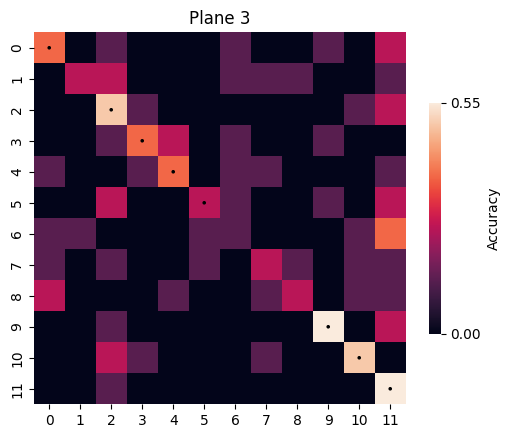

In [30]:
classifier = 'SVM'
method = 'L1O'

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title(f'Plane {plane}')

confusion_mat, confusion_shf, confusion_z, _,  decoding_weights, decoding_weights_z = dc.cross_validate(X, Y, classifier=classifier, method=method, shuffle=True, plot_shuffle=False, parallel=False)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,annot=False,ax=ax)
    


In [91]:
decoding_weights_z.shape

(12, 483)

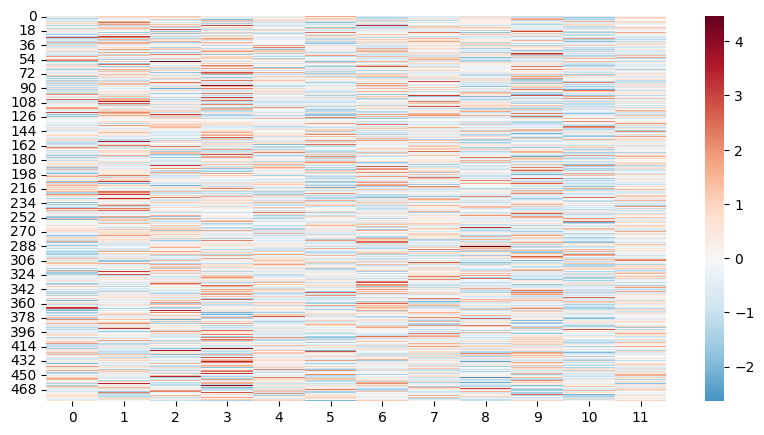

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))


dw = decoding_weights_z.T
ax.set_ylabel('Neurons')

ax.set_xlabel('Stimulus ID')
ax.set_xticks(np.arange(nStim))
ax.set_xticklabels(unique_stimIDs)

mask = (dw > 2) | (dw < -2)
sns.heatmap(dw,ax=ax,cmap='RdBu_r',center=0)#,mask=~mask)

informative_neurons = np.where(np.sum(mask,axis=1) > 0)[0]
noninformative_neurons = np.setdiff1d(np.arange(nNeurons),informative_neurons)

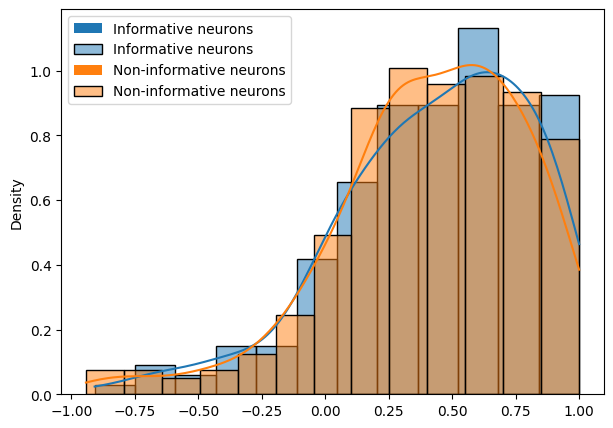

In [32]:
metrics_plane = metrics_sub.loc[metrics_sub.plane == plane]


fig, ax = plt.subplots(figsize=(7,5))
sns.histplot(metrics_plane.iloc[informative_neurons]['ssi'].values,stat='density',kde=True,ax=ax,label='Informative neurons')
sns.histplot(metrics_plane.iloc[noninformative_neurons]['ssi'].values,stat='density',kde=True, ax=ax,label='Non-informative neurons')

ax.legend()